# Extract the spectrum of the z=16 candidate in the CEERS field

Source identified by Donnan et al. (2022) and  Naidu et al. (2022).

NIRSpec data from DD-2750 (PI: Pablo Arrabal Haro), expected 24 March 2023.

*Pipeline steps*

1. Run the preprocessing pipline through extracting 2D cutouts
1. Drizzle the cutouts to a combined spectrum
1. Extract 1D spectrum
1. Fit redshift

In [1]:
# Are we on a GitHub codespace?
import os

if os.getcwd().startswith('/workspaces/msaexp'):
    import os
    os.environ['CRDS_PATH'] = os.path.join('/tmp/', 'crds_cache')

    if not os.path.exists(os.environ['CRDS_PATH']):
        ! mkdir {os.environ['CRDS_PATH']}

    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

    print('On codespace: ', os.environ['CRDS_PATH'], os.environ['CRDS_SERVER_URL'])

    workdir  = '/workspaces/msaexp/docs/examples/codespace'
    if not os.path.exists(workdir):
        ! mkdir {workdir}
    
    os.chdir(workdir)
else:
    print('(not on a codespace)')

On codespace:  /tmp/crds_cache https://jwst-crds.stsci.edu


In [2]:
import os
if 'CRDS_PATH' not in os.environ is None:
    os.environ['CRDS_PATH'] = f'{os.getcwd()}/crds_cache'

    if not os.path.exists(os.environ['CRDS_PATH']):
        os.makedirs(os.environ['CRDS_PATH'])

    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

In [2]:
import os
import glob
import yaml
import warnings

import numpy as np
import matplotlib.pyplot as plt

import grizli
from grizli import utils, jwst_utils
jwst_utils.set_quiet_logging()
utils.set_warnings()

import astropy.io.fits as pyfits
from jwst.datamodels import SlitModel
import jwst


import msaexp
from msaexp import pipeline

print(f'grizli version = {grizli.__version__}')
print(f'msaexp version = {msaexp.__version__}')
print(f'jwst version = {jwst.__version__}')

grizli version = 1.8.3
msaexp version = 0.1.dev1+g984b890
jwst version = 1.9.6


# Query MAST for NIRSpec data

Query by program name and download `rate.fits` files with `mastquery`.  May need to set `$MAST_TOKEN` environment variable to enable the downloads from MAST.

Can optionally limit the query to specific 

 - gratings:  ``prism``, ``g140m``, ``g235m``, ``g395m``, ``g140m``, ``g235m``, ``g395m``
 - filters:  ``clear``, ``f170lp``, ``f100lp``, ``f170lp``, ``f290lp``
 - detectors: ``nrs1``, ``nrs2``
 
 

In [5]:
# CEERS dropout
prog = 2750
gratings = ['prism']

outroot = 'ceers2750'

file_version = 'v1'
src_rd = utils.read_catalog("""# ra dec
214.914500 52.94304""")

# Set this to False and let it go for the new 2750 data!
if True:
    # RXJ2129 for testing
    prog = 2767
    detectors = ['nrs2']
    gratings = ['prism']

    outroot = 'rxj2129'
    src_rd = utils.read_catalog("""# ra dec
    322.4215529 0.0916869""")

    os.getcwd()

In [6]:
import time

# Query NIRSpec data for a program name
files = glob.glob(f'jw0{prog}*rate.fits')

while len(files) == 0:
    print(time.ctime())
    masks = pipeline.query_program(prog, download=True, detectors=detectors, gratings=gratings)
    files = glob.glob(f'jw0{prog}*rate.fits')
    
    if len(files) == 0:
        time.sleep(30)

print(files)


['jw02767005001_03105_00003_nrs2_rate.fits', 'jw02767005001_03105_00002_nrs2_rate.fits', 'jw02767005001_03105_00004_nrs2_rate.fits']


In [7]:
# Reprocess?

if grizli.__version__ >= 'xxxx1.8.3':
    from grizli import jwst_level1

    for file in files:
        _debug = jwst_level1.process_uncal_level1(file.replace('_rate','_uncal'),
                                         output_extension='_rate',
                                         jump_threshold=4,
                                         erode_snowballs=4,
                                         grow_snowballs=5,
                                         rescale_uncertainty=True,
                                        )

# Initialize pipeline

Exposures are grouped by detector and with a common `MSAMETFL` metadata file for the MSA setup.

In [8]:
files = glob.glob(f'jw0{prog}*rate.fits')

groups = pipeline.exposure_groups(files=files)

print('\nFiles:\n======')
print(yaml.dump(dict(groups)))

   N  value     
====  ==========
   3  jw02767005001-02-clear-prism-nrs2

Files:
jw02767005001-02-clear-prism-nrs2:
- jw02767005001_03105_00003_nrs2_rate.fits
- jw02767005001_03105_00002_nrs2_rate.fits
- jw02767005001_03105_00004_nrs2_rate.fits



## Preprocessing pipeline

1. Apply 1/f correction and identify "snowballs" on the `rate.fits` files
1. Remove "bias" (i.e., simple median) of each exposure
1. Rescale RNOISE array based on empty parts of the exposure
1. Run parts of the Level 2 JWST calibration pipeline ([calweb_spec2](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html#calwebb-spec2)):
    - [AssignWcs](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.assign_wcs.AssignWcsStep.html) : initialize WCS and populate slit bounding_box data
    - [Extract2dStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.extract_2d.Extract2dStep.html) : identify slits and set slit WCS
    - [FlatFieldStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.flatfield.FlatFieldStep.html#flatfieldstep) : slit-level flat field
    - [PathLossStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.pathloss.PathLossStep.html) : NIRSpec path loss
    - [PhotomStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.photom.PhotomStep.html) : Photometric calibration
    - Note that the `srctype`, `master_background`, `wavecorr` steps are not performed.  The background subtraction is done manually on the 2D slit cutouts.
1. Parse slit metadata
1. Save slit cutout files of the last pipeline step performed (`phot` = `PhotomStep`)

Subsequent re-initialization of the `NirspecPipeline` object and `full_pipeline` method will skip these steps and just load the saved slit cutouts.

In [9]:
for mode in groups:
    # Find the matching source
    pipe = pipeline.NirspecPipeline(mode=mode)

    idx, dr = src_rd.match_to_catalog_sky(pipe.msa.src_table)
    srcid = pipe.msa.src_table['source_id'][np.argmin(dr)]
    
    print(f'\n {mode} \n source_id: {srcid} dr={dr.min()}')

    # Run the pipeline to define slits, etc., but don't do extractions yet.  
    if not os.path.exists(f'{mode}.slits.yaml'):
        pipe = pipeline.NirspecPipeline(mode=mode,
                                        source_ids=[srcid],
                                       ) 
        
        pipe.full_pipeline(run_extractions=False,
                           initialize_bkg=False,
                           load_saved=None)
    else:
        print(f'Skip preprocessing: {pipe.mode}')

# (2023-03-24 17:44:20.525)
msaexp.NirspecPipeline: Initialize jw02767005001-02-clear-prism-nrs2
msaexp.NirspecPipeline: jw02767005001_03105_00002_nrs2_rate.fits
msaexp.NirspecPipeline: jw02767005001_03105_00003_nrs2_rate.fits
msaexp.NirspecPipeline: jw02767005001_03105_00004_nrs2_rate.fits
msaexp.NirspecPipeline: mode=jw02767005001-02-clear-prism-nrs2 exp_type=NRS_MSASPEC  msametfl=jw02767005001_02_msa.fits

 jw02767005001-02-clear-prism-nrs2 
 source_id: 11027 dr=0.0 arcsec
# (2023-03-24 17:44:20.982)
msaexp.NirspecPipeline: Initialize jw02767005001-02-clear-prism-nrs2
msaexp.NirspecPipeline: jw02767005001_03105_00002_nrs2_rate.fits
msaexp.NirspecPipeline: jw02767005001_03105_00003_nrs2_rate.fits
msaexp.NirspecPipeline: jw02767005001_03105_00004_nrs2_rate.fits
# (2023-03-24 17:44:21.114)
msaexp.utils.pad_msa_metafile: Trim jw02767005001_02_msa.fits to [11027]
msaexp.utils.pad_msa_metafile: pad = 0
msaexp.NirspecPipeline: mode=jw02767005001-02-clear-prism-nrs2 exp_type=NRS_MSASPEC  ms

2023-03-24 17:44:22,252 - stpipe - WARNING - /home/codespace/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1095: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)



exposure_oneoverf_correction: jw02767005001_03105_00002_nrs2_rate.fits apply to file
exposure_oneoverf_correction: jw02767005001_03105_00002_nrs2_rate.fits axis=1 deg_pix=2048
exposure_oneoverf_correction: jw02767005001_03105_00002_nrs2_rate.fits apply to file
exposure_oneoverf_correction: jw02767005001_03105_00003_nrs2_rate.fits axis=0 deg_pix=256
exposure_oneoverf_correction: jw02767005001_03105_00003_nrs2_rate.fits apply to file
exposure_oneoverf_correction: jw02767005001_03105_00003_nrs2_rate.fits axis=1 deg_pix=2048
exposure_oneoverf_correction: jw02767005001_03105_00003_nrs2_rate.fits apply to file
exposure_oneoverf_correction: jw02767005001_03105_00004_nrs2_rate.fits axis=0 deg_pix=256
exposure_oneoverf_correction: jw02767005001_03105_00004_nrs2_rate.fits apply to file
exposure_oneoverf_correction: jw02767005001_03105_00004_nrs2_rate.fits axis=1 deg_pix=2048
exposure_oneoverf_correction: jw02767005001_03105_00004_nrs2_rate.fits apply to file
msaexp.preprocess : jw02767005001_031

2023-03-24 17:46:01,220 - stpipe.MSAFlagOpenStep - WARNING - /home/codespace/.python/current/lib/python3.10/site-packages/astropy/modeling/bounding_box.py:86: RuntimeWarning: Invalid interval: upper bound -256.40225155770986 is strictly less than lower bound -0.5.
  warnings.warn(

2023-03-24 17:46:02,050 - stpipe.MSAFlagOpenStep - WARNING - /home/codespace/.python/current/lib/python3.10/site-packages/astropy/modeling/bounding_box.py:86: RuntimeWarning: Invalid interval: upper bound -252.2959571914389 is strictly less than lower bound -0.5.
  warnings.warn(

2023-03-24 17:46:02,601 - stpipe.MSAFlagOpenStep - WARNING - /home/codespace/.python/current/lib/python3.10/site-packages/astropy/modeling/bounding_box.py:86: RuntimeWarning: Invalid interval: upper bound -600.9594491649505 is strictly less than lower bound -0.5.
  warnings.warn(

2023-03-24 17:46:03,424 - stpipe.MSAFlagOpenStep - WARNING - /home/codespace/.python/current/lib/python3.10/site-packages/astropy/modeling/bounding_box.p

# (2023-03-24 17:46:11.435)
msaexp.jwst.MSAFlagOpenStep: jw02767005001_03105_00003_nrs2_rate.fits


2023-03-24 17:46:21,583 - stpipe.MSAFlagOpenStep - WARNING - /home/codespace/.python/current/lib/python3.10/site-packages/astropy/modeling/bounding_box.py:86: RuntimeWarning: Invalid interval: upper bound -256.40225155770986 is strictly less than lower bound -0.5.
  warnings.warn(

2023-03-24 17:46:22,446 - stpipe.MSAFlagOpenStep - WARNING - /home/codespace/.python/current/lib/python3.10/site-packages/astropy/modeling/bounding_box.py:86: RuntimeWarning: Invalid interval: upper bound -252.2959571914389 is strictly less than lower bound -0.5.
  warnings.warn(

2023-03-24 17:46:23,011 - stpipe.MSAFlagOpenStep - WARNING - /home/codespace/.python/current/lib/python3.10/site-packages/astropy/modeling/bounding_box.py:86: RuntimeWarning: Invalid interval: upper bound -600.9594491649505 is strictly less than lower bound -0.5.
  warnings.warn(

2023-03-24 17:46:23,858 - stpipe.MSAFlagOpenStep - WARNING - /home/codespace/.python/current/lib/python3.10/site-packages/astropy/modeling/bounding_box.p

# (2023-03-24 17:46:31.896)
msaexp.jwst.MSAFlagOpenStep: jw02767005001_03105_00004_nrs2_rate.fits


2023-03-24 17:46:41,625 - stpipe.MSAFlagOpenStep - WARNING - /home/codespace/.python/current/lib/python3.10/site-packages/astropy/modeling/bounding_box.py:86: RuntimeWarning: Invalid interval: upper bound -256.40225155770986 is strictly less than lower bound -0.5.
  warnings.warn(

2023-03-24 17:46:42,531 - stpipe.MSAFlagOpenStep - WARNING - /home/codespace/.python/current/lib/python3.10/site-packages/astropy/modeling/bounding_box.py:86: RuntimeWarning: Invalid interval: upper bound -252.2959571914389 is strictly less than lower bound -0.5.
  warnings.warn(

2023-03-24 17:46:43,107 - stpipe.MSAFlagOpenStep - WARNING - /home/codespace/.python/current/lib/python3.10/site-packages/astropy/modeling/bounding_box.py:86: RuntimeWarning: Invalid interval: upper bound -600.9594491649505 is strictly less than lower bound -0.5.
  warnings.warn(

2023-03-24 17:46:43,970 - stpipe.MSAFlagOpenStep - WARNING - /home/codespace/.python/current/lib/python3.10/site-packages/astropy/modeling/bounding_box.p

# (2023-03-24 17:46:52.060)
msaexp.jwst.Extract2dStep: jw02767005001_03105_00002_nrs2_rate.fits
# (2023-03-24 17:46:52.896)
msaexp.jwst.Extract2dStep: jw02767005001_03105_00003_nrs2_rate.fits
# (2023-03-24 17:46:53.628)
msaexp.jwst.Extract2dStep: jw02767005001_03105_00004_nrs2_rate.fits
# (2023-03-24 17:46:54.359)
msaexp.jwst.FlatFieldStep: jw02767005001_03105_00002_nrs2_rate.fits
# (2023-03-24 17:47:32.741)
msaexp.jwst.FlatFieldStep: jw02767005001_03105_00003_nrs2_rate.fits
# (2023-03-24 17:47:36.672)
msaexp.jwst.FlatFieldStep: jw02767005001_03105_00004_nrs2_rate.fits
# (2023-03-24 17:47:40.446)
msaexp.jwst.PathLossStep: jw02767005001_03105_00002_nrs2_rate.fits
# (2023-03-24 17:47:42.150)
msaexp.jwst.PathLossStep: jw02767005001_03105_00003_nrs2_rate.fits
# (2023-03-24 17:47:42.803)
msaexp.jwst.PathLossStep: jw02767005001_03105_00004_nrs2_rate.fits
# (2023-03-24 17:47:43.463)
msaexp.jwst.BarShadowStep: jw02767005001_03105_00002_nrs2_rate.fits
# (2023-03-24 17:47:45.181)
msaexp.jwst.Bar

In [10]:
files = glob.glob(f'{mode}*')
files.sort()
for f in files:
    print(f)

jw02767005001-02-clear-prism-nrs2.log.txt
jw02767005001-02-clear-prism-nrs2.reg
jw02767005001-02-clear-prism-nrs2.slits.yaml


In [11]:
print('Pipeline entries: ', list(pipe.pipe.keys()))
print('Last step: ', pipe.last_step)
print(pipe.mode)

Pipeline entries:  ['wcs', 'open', '2d', 'flat', 'path', 'bar', 'phot']
Last step:  phot
jw02767005001-02-clear-prism-nrs2


## Extracted spectra 

The end products of the preprocessing pipeline are 2D calibrated spectra ([jwst.datamodels.SlitModel](https://jwst-pipeline.readthedocs.io/en/stable/api/jwst.datamodels.SlitModel.html)) for each slitlet.

In [12]:
target = f'{srcid}'
#target = '11027' # z=9.5 Williams et al.
# target = '3593'

slit_files = glob.glob(f"*phot*_{target}.fits")

slit_files.sort()

slit_files

['jw02767005001_03105_00002_nrs2_phot.000.2767_11027.fits',
 'jw02767005001_03105_00003_nrs2_phot.000.2767_11027.fits',
 'jw02767005001_03105_00004_nrs2_phot.000.2767_11027.fits']

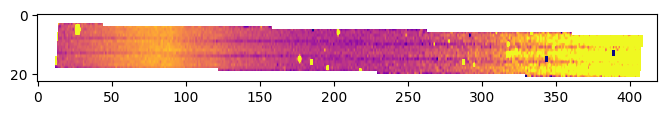

In [13]:
dm = SlitModel(slit_files[0])

sh = dm.data.shape
fig, ax = plt.subplots(1,1,figsize=(8,8*sh[0]/sh[1]*2))
ax.imshow(dm.data, aspect='auto',
          cmap='plasma', vmin=-0.1, vmax=0.5)

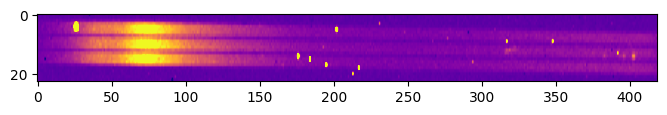

In [14]:
# From original detector image

exp = pyfits.open(f"{dm.meta.filename.split('_phot')[0]}_rate.fits")

slx = slice(dm.xstart, dm.xstart + dm.xsize)
sly = slice(dm.ystart, dm.ystart + dm.ysize)

fig, ax = plt.subplots(1,1,figsize=(8,8*sh[0]/sh[1]*2))
ax.imshow(exp['SCI'].data[sly, slx], aspect='auto',
          cmap='plasma', vmin=-0.1, vmax=0.5)

dm.close()

# Drizzle-combine 2D spectra

msaexp.drizzle.drizzle_slitlets: 11027 read 3 files
msaexp.drizzle.drizzle_slitlets: id=11027  prism-clear N=3
msaexp.drizzle.drizzle_slitlets: get wcs from slit 0 =  2767_11027
msaexp.drizzle.drizzle_slitlets: output size = (31, 414)
msaexp.drizzle.drizzle_slitlets: prism-clear  0 2767_11027             11027 -0.081 jw02767005001_03105_00002_nrs2_phot.000.2767_11027.fits (23, 419)
msaexp.drizzle.drizzle_slitlets: prism-clear  1 2767_11027             11027 -0.089 jw02767005001_03105_00003_nrs2_phot.000.2767_11027.fits (23, 419)
msaexp.drizzle.drizzle_slitlets: prism-clear  2 2767_11027             11027 -0.073 jw02767005001_03105_00004_nrs2_phot.000.2767_11027.fits (23, 419)


2023-03-24 17:48:15,215 - stpipe - WARNING - VerifyWarning: Card is too long, comment will be truncated.


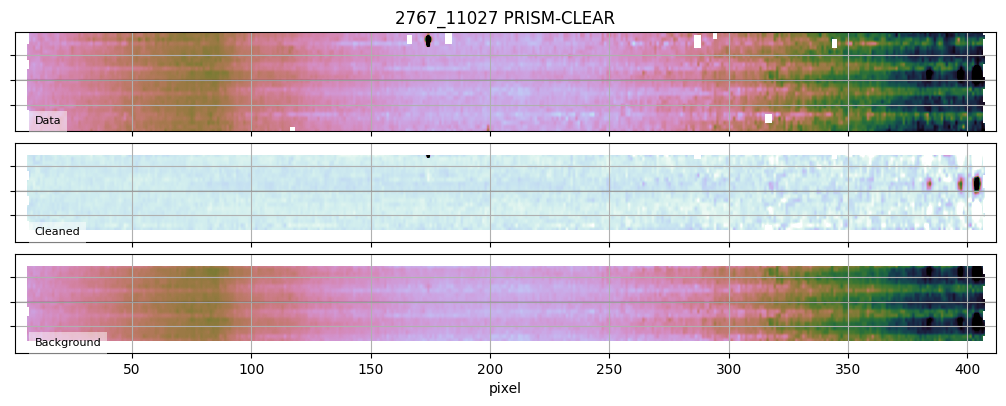

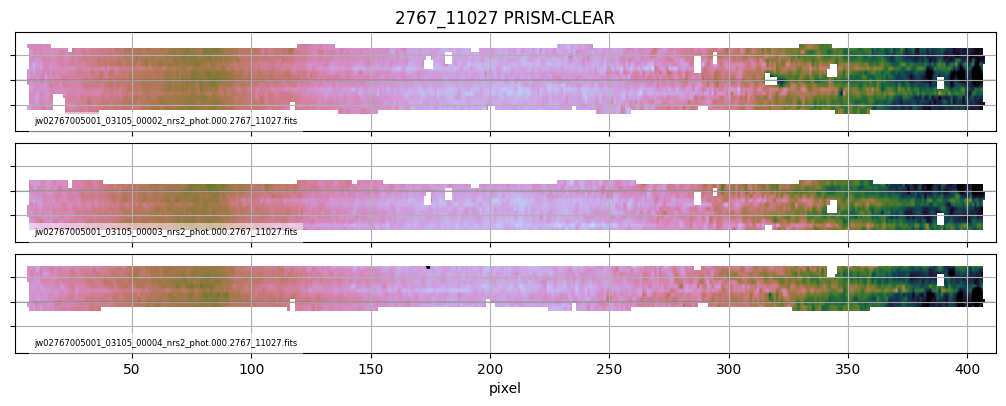

In [15]:
from importlib import reload
import copy

import msaexp.drizzle
reload(msaexp.drizzle); reload(msaexp.utils)
reload(msaexp.drizzle); reload(msaexp.utils) 

DRIZZLE_PARAMS = copy.deepcopy(msaexp.drizzle.DRIZZLE_PARAMS)
DRIZZLE_PARAMS['kernel'] = 'square'
DRIZZLE_PARAMS['pixfrac'] = 1.0

_ = msaexp.drizzle.drizzle_slitlets(target,
                                    output=outroot,
                                    files=slit_files[:],
                                    center_on_source=False,  # Center output source as defined in MSA file.  Leave False and can maybe build master bkg
                                    fix_slope=0.2,          # Cross-dispersion scale dslit/dpix
                                    force_nypix=31,         # Y size of output array
                                    bkg_offset=6,           # Number of pixels to roll for background subtraction
                                    bkg_parity=[-1,1],      # Roll directions for background, i.e., -1 rolls the array down for bkg at top
                                    log_step=False,         # Log wavelength steps
                                    outlier_threshold=10,   # Outlier rejection threshold
                                    err_threshold=1000,     # Reject pixels in a slit where err > err_threshold*median(err)
                                    show_drizzled=True,     # Figures
                                    show_slits=True,
                                    imshow_kws=dict(vmin=-0.05, vmax=0.4, aspect='auto', cmap='cubehelix_r'),
                                    sn_threshold=-np.inf,   # Reject pixels where S/N < sn_threshold.  Prism S/N should usually be > 5 with bkg
                                    bar_threshold=0.0,      # Mask pixels where barshadow array less than this value
                                   )

figs, hdu_data, wavedata, all_slits, drz_data = _


# Optimal 1D extraction

msaexp.drizzle.extract_from_hdul: Initial center =  -0.61, sigma =   0.90
msaexp.drizzle.extract_from_hdul:  Output center =   1.67, sigma =   0.71


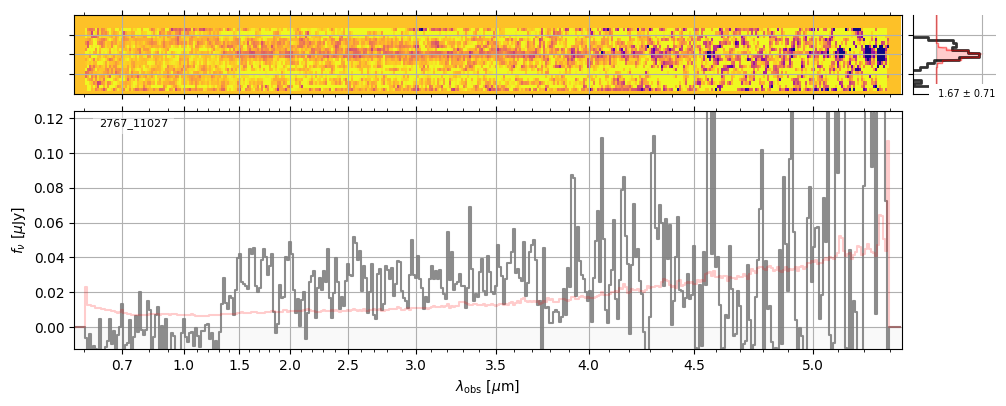

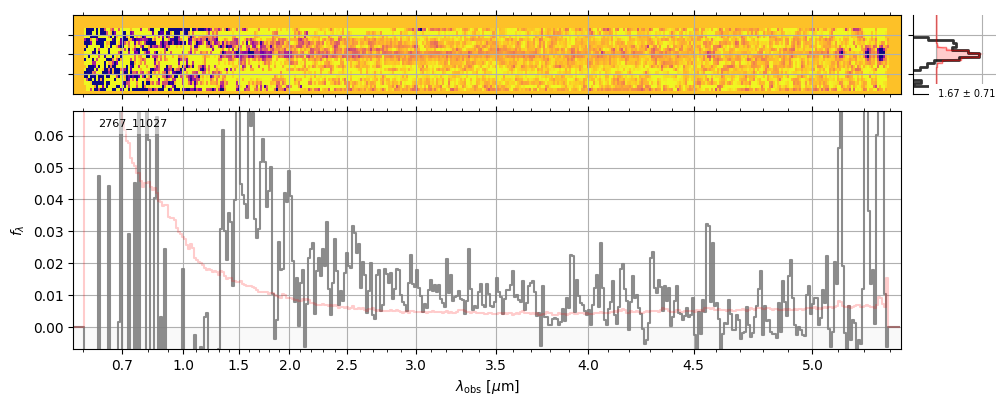

In [16]:
hdul = hdu_data['prism-clear']

outhdu = msaexp.drizzle.extract_from_hdul(hdul,
                                          prf_sigma=0.9, fix_sigma=False,
                                          prf_center=None, fix_center=False,
                                          verbose=True,
                                          )

outhdu.writeto(f'{outroot}_{target}.{file_version}.spec.fits', overwrite=True)

# Make figures
fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='fnu')
fig.savefig(f'{outroot}_{target}.{file_version}.fnu.png')

fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='flam')
fig.savefig(f'{outroot}_{target}.{file_version}.flam.png')


# Fit redshift

In [18]:
import eazy

try:
    _ = templ # already defined
except:
    if not os.path.exists('templates'):
        eazy.symlink_eazy_inputs()

    otempl = eazy.templates.read_templates_file('templates/sfhz/blue_sfhz_13.param')

    if 1:
        wrest = utils.log_zgrid([300, 5.5e4], 1./500)
        print(wrest.shape)
        templ = []
        for i, t in enumerate(otempl):
            print(i, t.name)
            templ.append(t.smooth_velocity(500., in_place=False))
            templ[-1].resample(wrest, in_place=True)
    else:
        templ = otempl
    

Cloning into 'eazy-photoz'...
2023-03-24 17:48:40,943 - stpipe - WARNING - /home/codespace/.python/current/lib/python3.10/site-packages/eazy/templates.py:356: ResourceWarning: unclosed file <_io.TextIOWrapper name='templates/sfhz/blue_sfhz_13.param' mode='r' encoding='UTF-8'>
  lines = open(templates_file).readlines()



cloning https://github.com/gbrammer/eazy-photoz.git to /home/codespace/.python/current/lib/python3.10/site-packages/eazy/data/
/home/codespace/.python/current/lib/python3.10/site-packages/eazy/data/templates -> ./templates
/home/codespace/.python/current/lib/python3.10/site-packages/eazy/data/filters/FILTER.RES.latest -> ./FILTER.RES.latest
(2604,)
0 corr_sfhz_13_bin0_av0.01.fits
1 corr_sfhz_13_bin0_av0.25.fits
2 corr_sfhz_13_bin0_av0.50.fits
3 corr_sfhz_13_bin0_av1.00.fits
4 corr_sfhz_13_bin1_av0.01.fits
5 corr_sfhz_13_bin1_av0.25.fits
6 corr_sfhz_13_bin1_av0.50.fits
7 corr_sfhz_13_bin1_av1.00.fits
8 corr_sfhz_13_bin2_av0.01.fits
9 corr_sfhz_13_bin2_av0.50.fits
10 corr_sfhz_13_bin2_av1.00.fits
11 corr_sfhz_13_bin3_av0.01.fits
12 corr_sfhz_13_bin3_av0.50.fits
13 fsps_4590.fits


896it [00:06, 138.59it/s]
101it [00:00, 153.71it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# rxj2129_11027.v1.spec.fits
# z = 9.50971
# Fri Mar 24 17:49:15 2023

# line flux err
# flux x 10^-20 erg/s/cm2
# rxj2129_11027.v1.spec.fits
# z = 9.50971
# Fri Mar 24 17:49:15 2023
             line Hb       94.2 ±      8.9
             line Hg       45.4 ±      7.7
             line Hd       33.4 ±      6.7
     line NeIII-3968       27.5 ±      7.6
      line OIII-4959      149.5 ±      8.4
      line OIII-5007      422.6 ±     12.4
      line OIII-4363       24.0 ±      7.5
            line OII       29.8 ±      6.8
      line HeII-4687        6.8 ±      6.6
     line NeIII-3867       29.4 ±      7.1
       line HeI-3889      -12.0 ±      6.6
      line OIII-1663      107.9 ±     33.4
      line CIII-1908      123.3 ±     26.3
      line NIII-1750        2.3 ±     31.9
            line Lya     -146.0 ±     91.4
           line MgII      -17.0 ±     10.0
       line NeV-3346       12.4 ±      7.2
      line NeVI-3426       19.0 ±      6.8


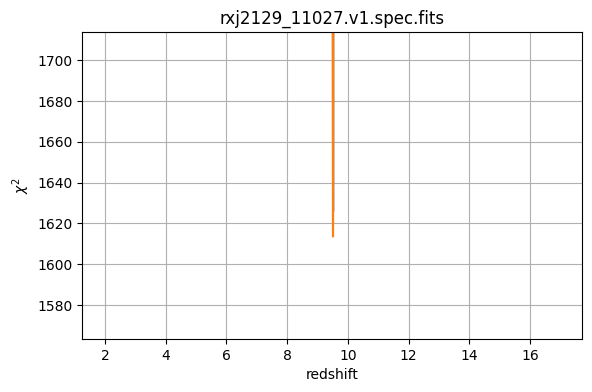

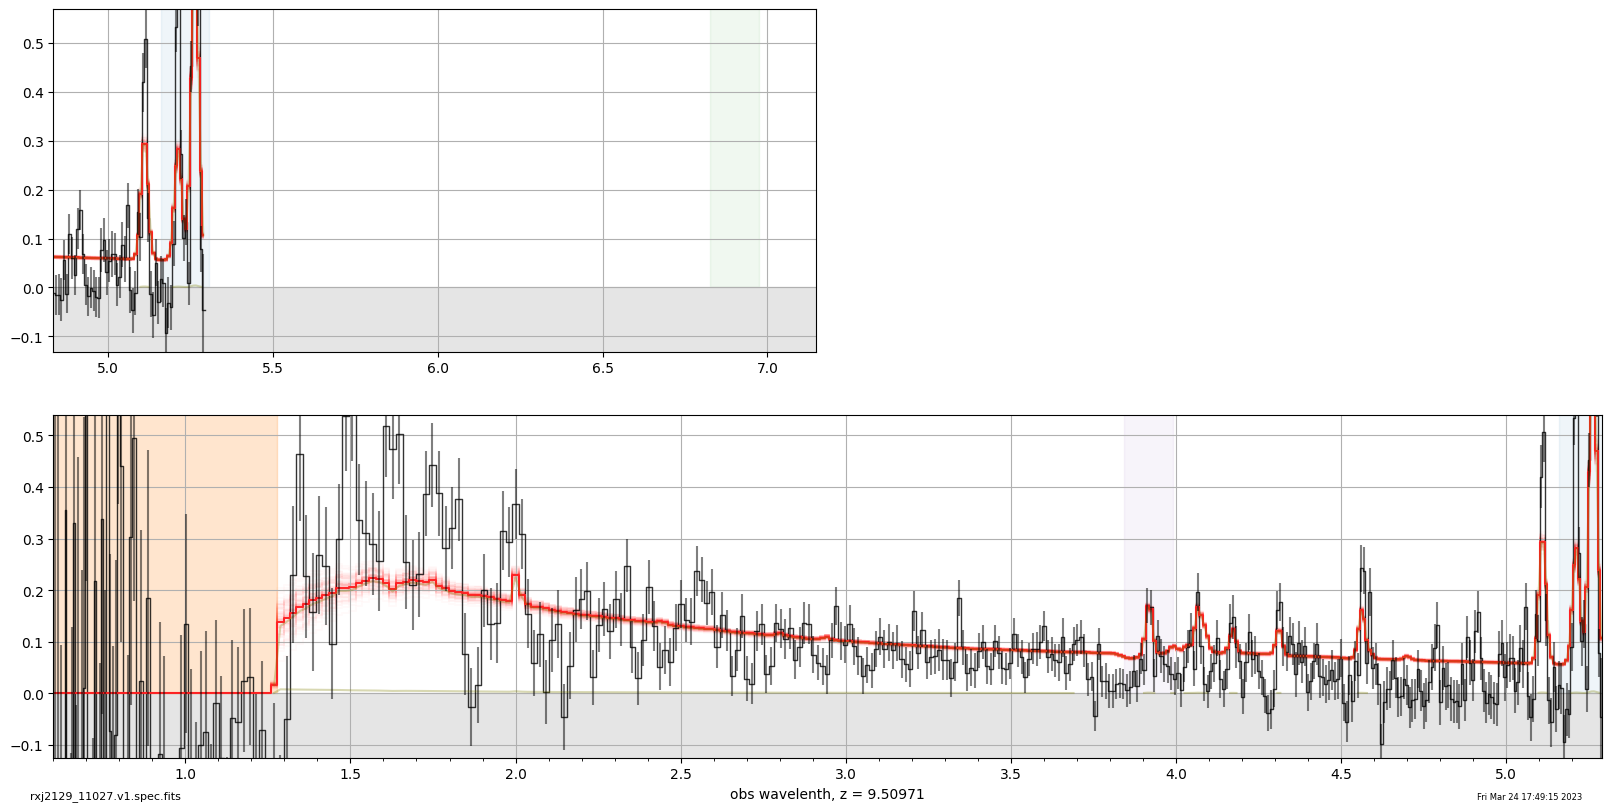

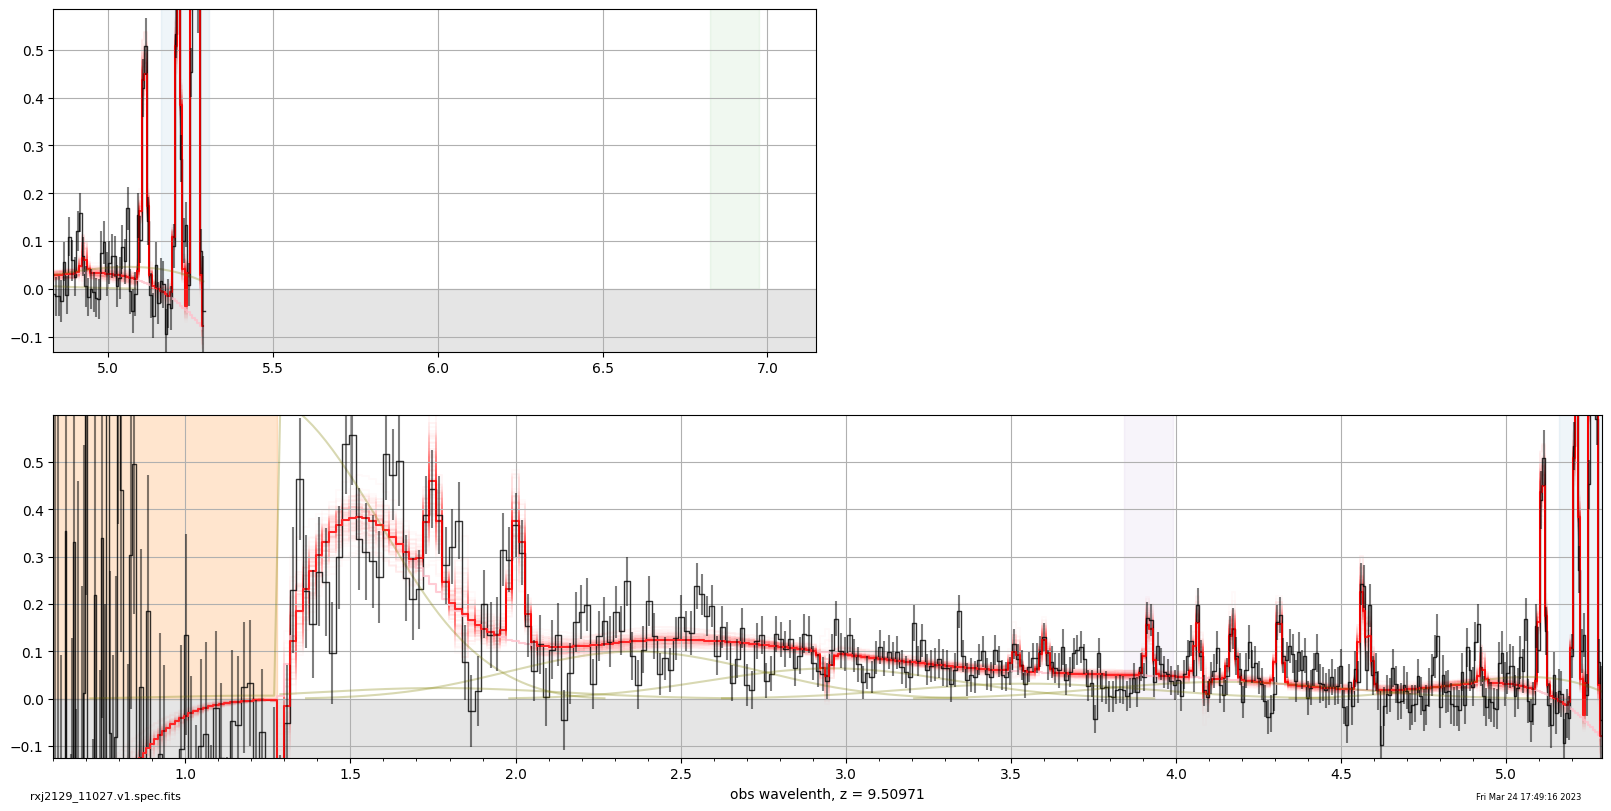

In [19]:
import msaexp.spectrum
import astropy.units as u

msaexp.spectrum.FFTSMOOTH = True
msaexp.spectrum.SCALE_UNCERTAINTY = 1.

file = f'{outroot}_{target}.{file_version}.spec.fits'

zfit_kwargs = dict(z0=[2.0, 17],
                   eazy_templates=templ,
                   vel_width=50,
                   scale_disp=1.0,
                   nspline=11,
                   Rline=2000,
                   use_full_dispersion=False,
                   is_prism=True,
                   sys_err=0.02,
                   ranges=((4600, 6800), (8800, 1.1e4)),
                  )

plt_kwargs = dict(eazy_templates=None,
                  vel_width=50,
                  scale_disp=1.3,
                  nspline=11,
                  Rline=2000,
                  use_full_dispersion=True,
                  is_prism=True,
                  sys_err=0.02,
                  ranges=((4600, 6800), (8800, 1.1e4)),
                  scale_uncertainty_kwargs={'order':1},
                  plot_unit=u.microJansky,
                  )

zfit = msaexp.spectrum.fit_redshift(file=file, **zfit_kwargs)



Set SCALE_UNCERTAINTY:  [-0.01557027  0.08003644]

# line flux err
# flux x 10^-20 erg/s/cm2
# rxj2129_11027.v1.spec.fits
# z = 9.50971
# Fri Mar 24 17:49:20 2023
             line Hb       81.8 ±      8.0
             line Hg       41.5 ±      6.9
             line Hd       29.7 ±      6.1
     line NeIII-3968       24.4 ±      7.0
      line OIII-4959      120.5 ±      7.3
      line OIII-5007      370.8 ±     10.9
      line OIII-4363       23.4 ±      6.8
            line OII       28.3 ±      6.3
      line HeII-4687        6.8 ±      5.9
     line NeIII-3867       25.7 ±      6.4
       line HeI-3889       -8.5 ±      5.8
      line OIII-1663       89.0 ±     32.7
      line CIII-1908      102.8 ±     25.5
      line NIII-1750        1.3 ±     31.2
            line Lya     -118.7 ±     88.5
           line MgII      -15.7 ±      9.6
       line NeV-3346       11.2 ±      6.8
      line NeVI-3426       16.1 ±      6.2


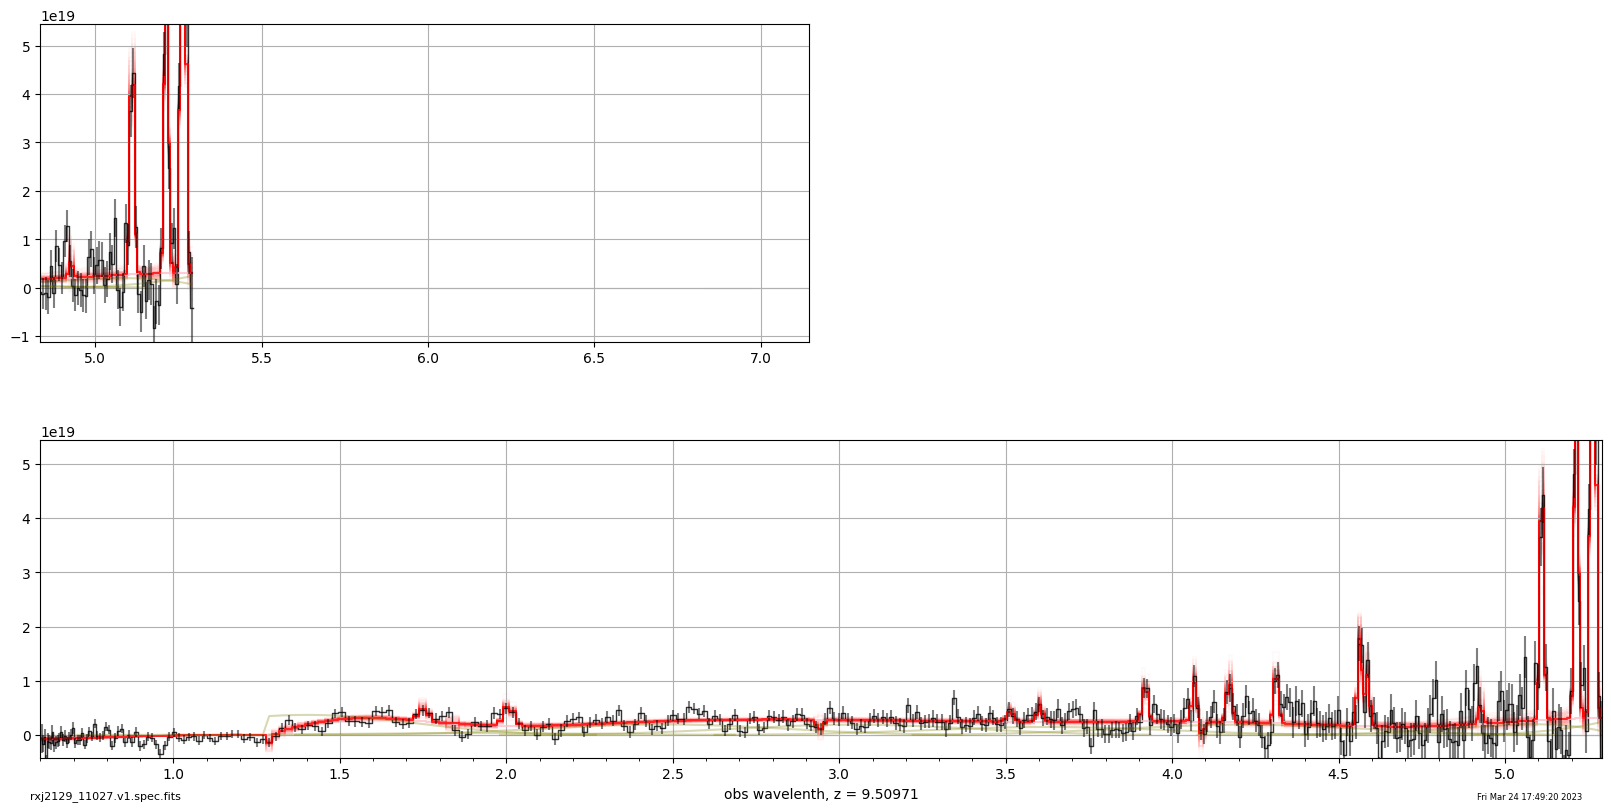

In [20]:
reload(msaexp.spectrum)

best_z = zfit[1].meta['z']

if target in ['3349', '3593', '3314']:
    best_z = 10.17145

msaexp.spectrum.SCALE_UNCERTAINTY = 1.

_ = msaexp.spectrum.plot_spectrum(file=file,
                                  z=best_z,
                                  **plt_kwargs,
                                  )

402it [00:06, 59.12it/s]
101it [00:01, 57.50it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# rxj2129_11027.v1.spec.fits
# z = 9.50999
# Fri Mar 24 17:49:31 2023
             line Hb       94.1 ±      8.9
             line Hg       45.7 ±      7.8
             line Hd       33.4 ±      6.9
     line NeIII-3968       27.3 ±      7.9
      line OIII-4959      149.5 ±      8.4
      line OIII-5007      423.1 ±     12.4
      line OIII-4363       24.0 ±      7.6
            line OII       29.7 ±      7.1
      line HeII-4687        6.4 ±      6.7
     line NeIII-3867       29.3 ±      7.4
       line HeI-3889      -12.2 ±      6.8
      line OIII-1663      107.5 ±     37.7
      line CIII-1908      122.7 ±     29.4
      line NIII-1750        1.4 ±     35.8
            line Lya     -146.5 ±    104.6
           line MgII      -17.1 ±     10.8
       line NeV-3346       12.5 ±      7.7
      line NeVI-3426       19.2 ±      7.2


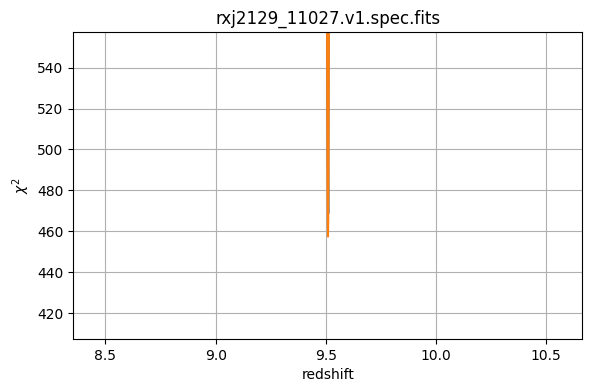

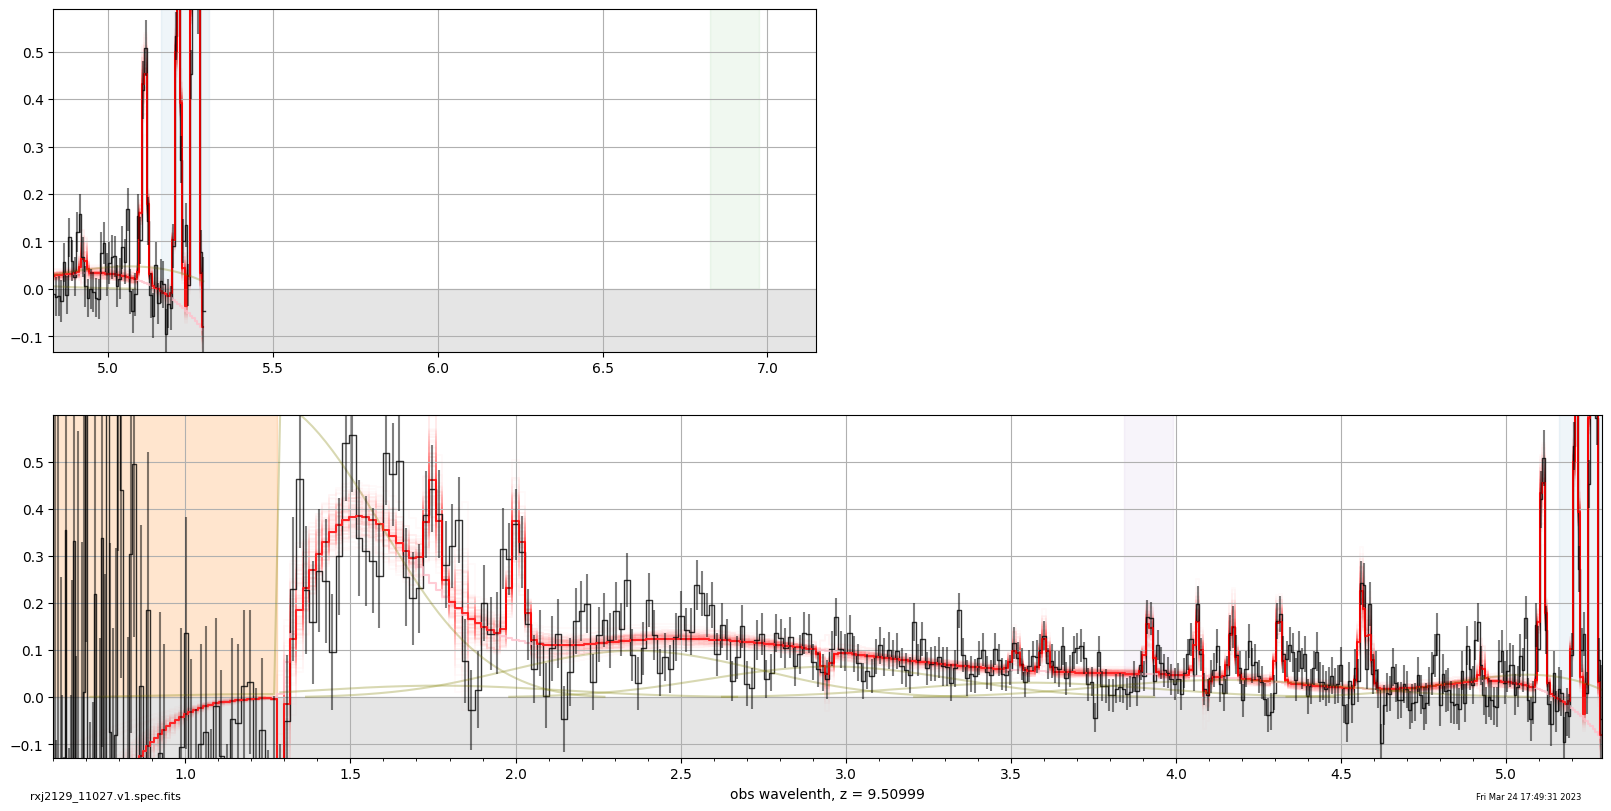

In [21]:
# Refit with just line templates

best_z = zfit[1].meta['z']

zfit_kwargs['z0'] = best_z + np.array([-0.1, 0.1])*(1+best_z)
zfit_kwargs['eazy_templates'] = None

zfit = msaexp.spectrum.fit_redshift(file=file, zstep=(0.0005, 0.0001), **zfit_kwargs)

best_z = zfit[1].meta['z']


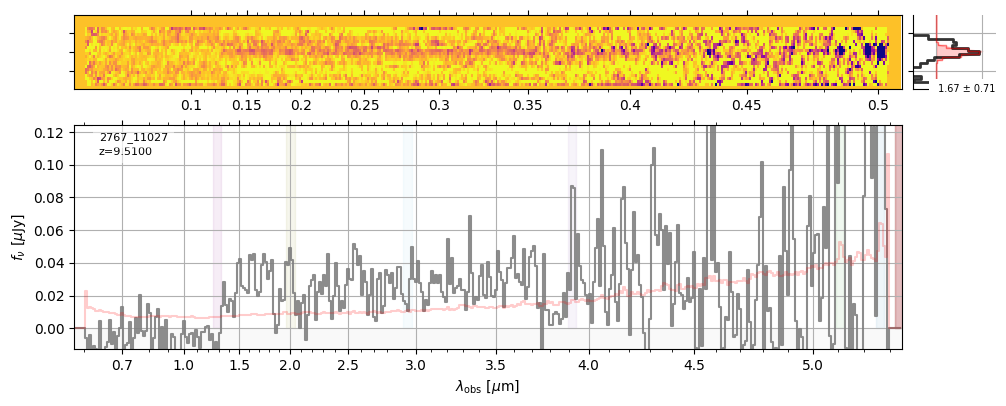

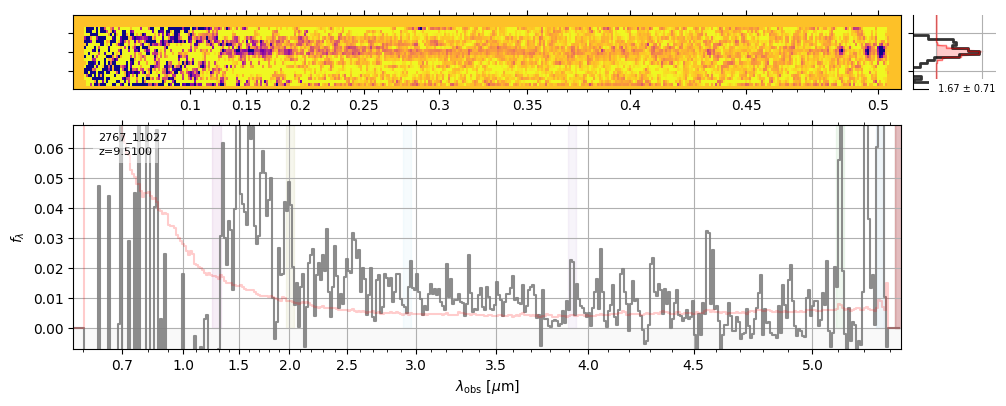

In [22]:
# Remake figures
fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='fnu', z=best_z)
fig.savefig(f'{outroot}_{target}.{file_version}.fnu.png')

fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='flam', z=best_z)
fig.savefig(f'{outroot}_{target}.{file_version}.flam.png')


# Extract all targets

In [21]:
files = glob.glob(f'{mode}*')
files += glob.glob('*_phot*')
for file in files:
    os.remove(file)

In [ ]:
for mode in groups:
    # Run the pipeline to define slits, etc., but don't do extractions yet.  
    if True: #not os.path.exists(f'{mode}.slits.yaml'):
        pipe = pipeline.NirspecPipeline(mode=mode,
                                       ) 
        
        pipe.full_pipeline(run_extractions=False,
                           initialize_bkg=False,
                           load_saved=None)
    else:
        print(f'Skip preprocessing: {pipe.mode}')

# (2023-03-24 17:38:51.252)
msaexp.NirspecPipeline: Initialize jw02767005001-02-clear-prism-nrs2
msaexp.NirspecPipeline: jw02767005001_03105_00002_nrs2_rate.fits
msaexp.NirspecPipeline: jw02767005001_03105_00003_nrs2_rate.fits
msaexp.NirspecPipeline: jw02767005001_03105_00004_nrs2_rate.fits
msaexp.NirspecPipeline: mode=jw02767005001-02-clear-prism-nrs2 exp_type=NRS_MSASPEC  msametfl=jw02767005001_02_msa.fits
# (2023-03-24 17:38:51.334)

prep.mask_snowballs(**{'visit': {'product': 'jw02767005001-02-clear-prism-nrs2', 'files': ['jw02767005001_03105_00002_nrs2_rate.fits', 'jw02767005001_03105_00003_nrs2_rate.fits', 'jw02767005001_03105_00004_nrs2_rate.fits']}, 'snowball_erode': 8, 'snowball_dilate': 24, 'mask_bit': 1024, 'instruments': ['NIRSPEC'], 'max_fraction': 0.3, 'unset4': False, 'kwargs': {}})

Snowball mask: jw02767005001_03105_00002_nrs2_rate.fits  N=  9(f=0.38%)
Snowball mask: jw02767005001_03105_00003_nrs2_rate.fits  N= 15(f=0.64%)
Snowball mask: jw02767005001_03105_00004_nrs2_

2023-03-24 18:39:26,529 - stpipe.MSAFlagOpenStep - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:86: RuntimeWarning: Invalid interval: upper bound -256.40225155771077 is strictly less than lower bound -0.5.
  warnings.warn(

2023-03-24 18:39:26,820 - stpipe.MSAFlagOpenStep - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:86: RuntimeWarning: Invalid interval: upper bound -252.29595719144345 is strictly less than lower bound -0.5.
  warnings.warn(

2023-03-24 18:39:27,140 - stpipe.MSAFlagOpenStep - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:86: RuntimeWarning: Invalid interval: upper bound -600.9594491649536 is strictly less than lower bound -0.5.
  warnings.warn(

2023-03-24 18:39:27,433 - stpipe.MSAFlagOpenStep - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/astrop

# (2023-03-24 17:39:31.589)
msaexp.jwst.MSAFlagOpenStep: jw02767005001_03105_00003_nrs2_rate.fits
# (2023-03-24 17:39:44.193)
msaexp.jwst.MSAFlagOpenStep: jw02767005001_03105_00004_nrs2_rate.fits
# (2023-03-24 17:39:56.595)
msaexp.jwst.Extract2dStep: jw02767005001_03105_00002_nrs2_rate.fits


In [ ]:
files = glob.glob('jw*phot*fits')

# files = glob.glob('jw01345070*nrs1*phot*1345_[0-9]*fits')

files.sort()


targets = [f.split('.')[-2].split('_')[-1] for f in files]
targets = np.unique(targets)

so = np.argsort(np.cast[int]([t.replace('m','-').replace('b','10000') for t in targets]))
targets = targets[so]
targets, len(targets)

In [ ]:
for t in targets:
    
    target = f'{t}'
    slit_files = glob.glob(f'*phot*_{t}.fits')
    slit_files.sort()
    
    if len(slit_files) == 0:
        continue
    
    try:
        
        _ = msaexp.drizzle.drizzle_slitlets(target,
                                        output=outroot,
                                        files=slit_files[:],
                                        center_on_source=False,  # Center output source as defined in MSA file.  Leave False and can maybe build master bkg
                                        fix_slope=0.2,          # Cross-dispersion scale dslit/dpix
                                        force_nypix=31,         # Y size of output array
                                        bkg_offset=6,           # Number of pixels to roll for background subtraction
                                        bkg_parity=[-1,1],      # Roll directions for background, i.e., -1 rolls the array down for bkg at top
                                        log_step=False,         # Log wavelength steps
                                        outlier_threshold=10,   # Outlier rejection threshold
                                        err_threshold=1000,     # Reject pixels in a slit where err > err_threshold*median(err)
                                        show_drizzled=True,     # Figures
                                        show_slits=True,
                                        imshow_kws=dict(vmin=-0.05, vmax=0.4, aspect='auto', cmap='cubehelix_r'),
                                        sn_threshold=-np.inf,   # Reject pixels where S/N < sn_threshold.  Prism S/N should usually be > 5 with bkg
                                        bar_threshold=0.0,      # Mask pixels where barshadow array less than this value
                                       )

        figs, hdu_data, wavedata, all_slits, drz_data = _
        
        hdul = hdu_data['prism-clear']

        outhdu = msaexp.drizzle.extract_from_hdul(hdul,
                                                  prf_sigma=0.9, fix_sigma=False,
                                                  prf_center=None, fix_center=False,
                                                  verbose=True,
                                                  )

        outhdu.writeto(f'{outroot}_{target}.{file_version}.spec.fits', overwrite=True)

        # Make figures
        fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='fnu')
        fig.savefig(f'{outroot}_{target}.{file_version}.fnu.png')

        fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='flam')
        fig.savefig(f'{outroot}_{target}.{file_version}.flam.png')

    except:
        continue


In [ ]:
# Break when running full notebook
print(break)

In [ ]:

def run_everything(target, skip=True):
    """
    Run all steps
    """
    
    if os.path.exists(f'{outroot}_{target}.{file_version}.flam.png') & skip:
        print(f'Skip: {target}')
        return True
    
    slit_files = glob.glob(f"*phot*_{target}.fits"))

    slit_files.sort()
    if len(slit_files) == 0:
        return False

    DRIZZLE_PARAMS = copy.deepcopy(msaexp.drizzle.DRIZZLE_PARAMS)
    DRIZZLE_PARAMS['kernel'] = 'square'
    DRIZZLE_PARAMS['pixfrac'] = 1.0

    _ = msaexp.drizzle.drizzle_slitlets(target,
                                        output=outroot,
                                        files=slit_files[:],
                                        center_on_source=False,  # Center output source as defined in MSA file.  Leave False and can maybe build master bkg
                                        fix_slope=0.2,          # Cross-dispersion scale dslit/dpix
                                        force_nypix=31,         # Y size of output array
                                        bkg_offset=6,           # Number of pixels to roll for background subtraction
                                        bkg_parity=[-1,1],      # Roll directions for background, i.e., -1 rolls the array down for bkg at top
                                        log_step=False,         # Log wavelength steps
                                        outlier_threshold=10,   # Outlier rejection threshold
                                        err_threshold=1000,     # Reject pixels in a slit where err > err_threshold*median(err)
                                        show_drizzled=True,     # Figures
                                        show_slits=True,
                                        imshow_kws=dict(vmin=-0.05, vmax=0.4, aspect='auto', cmap='cubehelix_r'),
                                        sn_threshold=-np.inf,   # Reject pixels where S/N < sn_threshold.  Prism S/N should usually be > 5 with bkg
                                        bar_threshold=0.0,      # Mask pixels where barshadow array less than this value
                                       )

    figs, hdu_data, wavedata, all_slits, drz_data = _

    # Optimal extraction
    hdul = hdu_data['prism-clear']

    outhdu = msaexp.drizzle.extract_from_hdul(hdul,
                                              prf_sigma=0.9, fix_sigma=False,
                                              prf_center=None, fix_center=False,
                                              verbose=True,
                                              )

    outhdu.writeto(f'{outroot}_{target}.{file_version}.spec.fits', overwrite=True)

    # Make figures
    fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='fnu')
    fig.savefig(f'{outroot}_{target}.{file_version}.fnu.png')

    fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='flam')
    fig.savefig(f'{outroot}_{target}.{file_version}.flam.png')

    # Fit redshift

    msaexp.spectrum.FFTSMOOTH = True

    file = f'{outroot}_{target}.{file_version}.spec.fits'

    zfit_kwargs = dict(z0=[1.0, 11],
                       eazy_templates=templ,
                       vel_width=50,
                       scale_disp=1.0,
                       nspline=11,
                       Rline=2000,
                       use_full_dispersion=False,
                       is_prism=True,
                       sys_err=0.02,
                       ranges=((4600, 6800), (8800, 1.1e4)),
                      )

    plt_kwargs = dict(eazy_templates=None,
                      vel_width=50,
                      scale_disp=1.0,
                      nspline=11,
                      Rline=2000,
                      use_full_dispersion=True,
                      is_prism=True,
                      sys_err=0.02,
                      ranges=((4600, 6800), (8800, 1.1e4)),
                      scale_uncertainty_kwargs={'order':4},
                      plot_unit=u.microJansky,
                      )

    zfit = msaexp.spectrum.fit_redshift(file=file, **zfit_kwargs)

    # Scale uncertainties
    best_z = zfit[1].meta['z']

    if target in ['3349', '3593', '3314']:
        best_z = 10.17145

    msaexp.spectrum.SCALE_UNCERTAINTY = 1.

    _ = msaexp.spectrum.plot_spectrum(file=file,
                                      z=best_z,
                                      **plt_kwargs,
                                      )

    #
    # Refit with just line templates

    best_z = zfit[1].meta['z']

    zfit_kwargs['z0'] = best_z + np.array([-0.1, 0.1])*(1+best_z)
    zfit_kwargs['eazy_templates'] = None

    zfit = msaexp.spectrum.fit_redshift(file=file, zstep=(0.0005, 0.0001), **zfit_kwargs)

    best_z = zfit[1].meta['z']
    
    # Remake figures
    fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='fnu', z=best_z)
    fig.savefig(f'{outroot}_{target}.{file_version}.fnu.png')

    fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='flam', z=best_z)
    fig.savefig(f'{outroot}_{target}.{file_version}.flam.png')
    
    return True


In [ ]:
for target in targets:
    try:
        run_everything(target)
    except:
        pass

    plt.close('all')